# Code for "Understanding Heart-Failure Patients EHR Clinical Features via SHAP Interpretation of Tree-Based Machine Learning Model Predictions"

**[@Frank-LSY](https://github.com/Frank-LSY)**

In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,auc, roc_curve, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Data cleaning

- All features that used are recorded in **[feature.xlsx](./feature.xlsx)**

In [3]:
df = pd.read_csv('../data/ef_original_cnt.csv') # read in the EHR data
df.drop(['Unnamed: 0'],axis=1,inplace=True)
head_lst = df.columns.values.tolist()

In [4]:
X = df.drop(['EF_SCORE'],axis=1)
y = df['EF_SCORE']
X_train_c, X_test_c, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train_c, X_valid_c, y_train, y_valid = train_test_split(X_train_c, y_train, test_size=0.2, random_state=0)
X_train = X_train_c.drop(['COUNT'],axis=1)
X_test = X_test_c.drop(['COUNT'],axis=1)

## Train the XGBoost regression model

In [5]:
# adjusted hyper parameters for XGBoost regression
params = {
    'eta': 0.34, 'n_estimators': 100, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 0.85, 'reg_lambda': 0.5, 'reg_alpha': 0.1,
                'seed': 33}

In [7]:
# xgbregressor model
model = xgb.XGBRegressor(**params)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [17]:
# Regression performance summary
import statsmodels.api as sm
from scipy import stats

X = y_test
y = y_pred

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     4697.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:18:50   Log-Likelihood:                -41620.
No. Observations:               13073   AIC:                         8.324e+04
Df Residuals:                   13071   BIC:                         8.326e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4024      0.174    208.900      0.0

Text(78, 95, 'F-statistic = 4697')

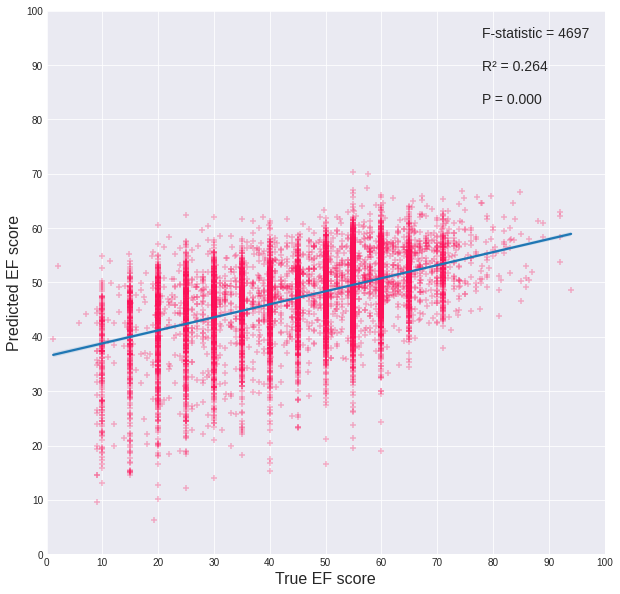

In [16]:
plt.style.use('seaborn-darkgrid')
df_pic = pd.DataFrame({'TEST':y_test,'PRED':y_pred})

fig = plt.figure(figsize=(10, 10))
sns.regplot(x = 'TEST',y = 'PRED',data = df_pic,
           marker='+',
           scatter_kws={"color":"#FF0F57","alpha":0.3,"s":40})
plt.xlabel('True EF score',fontsize=16)
plt.ylabel('Predicted EF score',fontsize=16)
plt.xticks(range(0,101,10))
plt.yticks(range(0,101,10))
# plt.title('XGBoost Regresion Result',fontsize=20)

plt.text(78,89,"R\u00b2 = 0.264",fontsize=14)
plt.text(78,83,"P = 0.000",fontsize=14)
plt.text(78,95,"F-statistic = 4697",fontsize=14)

In [ ]:
# XGBoost feature importance
f_importance = model.feature_importances_
head_lst = X_train.columns.values.tolist()
df_importance = pd.DataFrame({'head':head_lst,'importance':f_importance})
df_importance = df_importance.sort_values(by=['importance'],ascending=False) 

Text(0, 0.5, '')

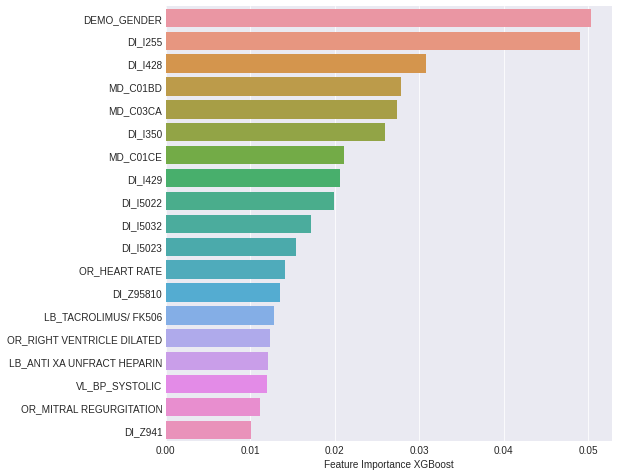

In [18]:
df_p_i = df_importance[df_importance['importance']>=0.01]
plt.gcf().set_size_inches(8,8)
sns.barplot(x='importance',y='head',data=df_p_i)
plt.xlabel('Feature Importance XGBoost', fontsize=10)
plt.ylabel('')

## Interpret the model and result with SHAP

In [19]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

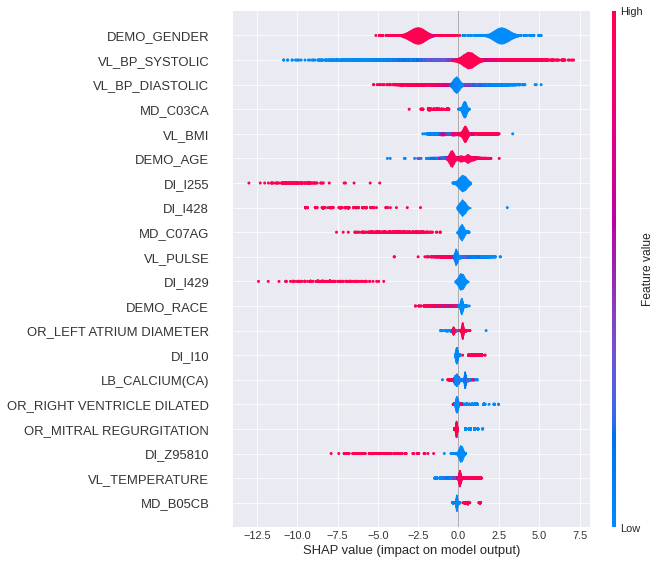

In [21]:
# SHAP Summary Plot
sum_shap_values = explainer.shap_values(X_test)
shap.summary_plot(sum_shap_values, X_test, max_display=20, plot_type="violin")

<Figure size 576x288 with 0 Axes>

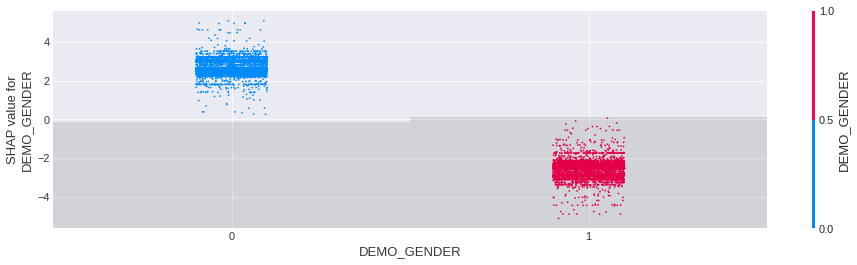

In [26]:
# Scatter plot for DEMO_GENDER
plt.figure(figsize=(8,4))
shap.plots.scatter(shap_values[:, "DEMO_GENDER"], color=shap_values[:,'DEMO_GENDER'],
                   dot_size=3, x_jitter=0.2,show=False)
plt.xticks((0,1))
plt.gcf().set_size_inches(16, 4)

Text(35, 7.5, 'B')

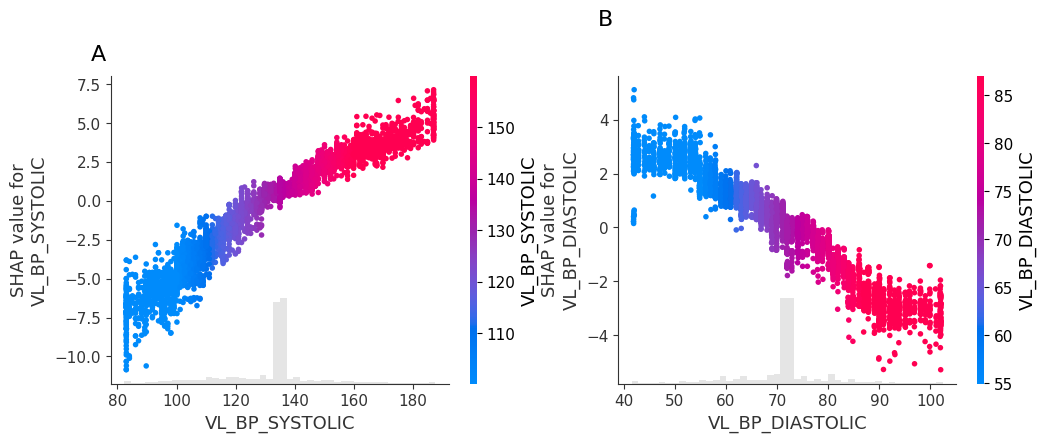

In [27]:
# Scatter plot for Blood Pressure
plt.style.use('default')

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,4))

shap.plots.scatter(shap_values[:, "VL_BP_SYSTOLIC"], color=shap_values[:,'VL_BP_SYSTOLIC'],show=False,ax=ax1)
plt.gcf().set_size_inches(12, 4)
plt.text(71,9,'A',fontsize=16)

shap.plots.scatter(shap_values[:, "VL_BP_DIASTOLIC"], color=shap_values[:,'VL_BP_DIASTOLIC'],show=False,ax=ax2)
plt.gcf().set_size_inches(12, 4)
plt.text(35,7.5,'B',fontsize=16)

## t-SNE supervised clustering with SHAP value

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [34]:
N = 13073 # Test data size
select = range(N)
features = X_test.iloc[select]
shap_tsne_values = explainer.shap_values(features)
ef_mean = y.mean()

In [30]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from pylab import *

# Define color map for figures
clist1 = ['#028BE7','#FEFEFE','#FF0F57']
clist2 = ['#CC194F','#FF0F57','#FF8AAD','#FEFEFE','#028BE7']
clist3 = ['#FF0F57','#FEFEFE','#028BE7','#2676AB']
clist4 = ['#FEFEFE','#7FC4F2','#CC194F','#FF0F57','#FF0F57','#FEFEFE']
clist5 = ['#68B2E3','#68B2E3','#68B2E3','#68B2E3','#68B2E3','#FF0F57']

clist_binary = ['#028BE7','#FEFEFE','#FF0F57']
clist_ef = ['#205F88','#2676AB','#028BE7','#FEFEFE','#FF0F57']
clist_pulse = ['#028BE7','#FEFEFE','#FF8AAD','#FF0F57']

In [31]:
# SHAP value clustering and dimension reduction with t-SNE
shap_embedded = TSNE(n_components=2, perplexity=100,n_jobs = -1).fit_transform(shap_tsne_values)

In [32]:
# Feature value clustering and dimension reduction with t-SNE
feature_embedded = TSNE(n_components=2, perplexity=100,n_jobs = -1).fit_transform(X_test)

(-72.7537883758545, 70.83796348571778, -72.61367206573486, 66.02940158843994)

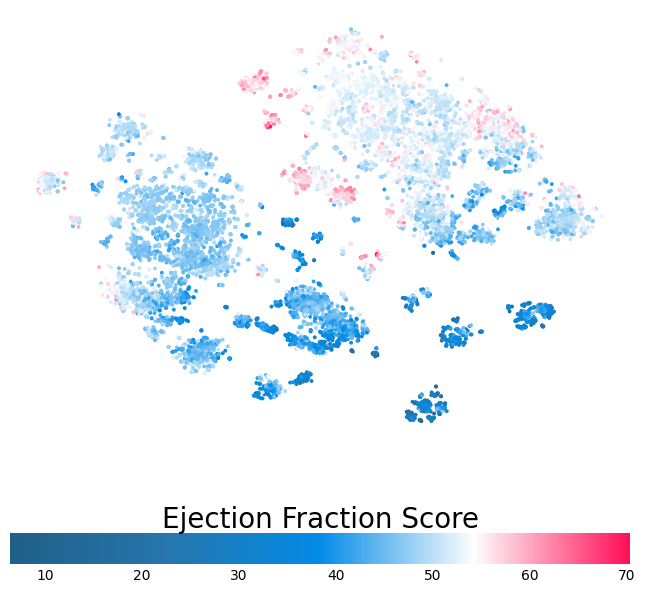

In [35]:
# SHAP value clustering visualizing
f = plt.figure(figsize=(8,8))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_tsne_values.sum(1).astype(np.float64)+ef_mean,
           linewidth=0, alpha=1, s = 8, cmap=LinearSegmentedColormap.from_list('shap2',clist_ef))
cb = plt.colorbar(aspect=20, orientation="horizontal")
cb.set_label("Ejection Fraction Score",fontsize=20)
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")

(-57.42050075531006, 53.167025566101074, -66.57588176727295, 59.83037166595459)

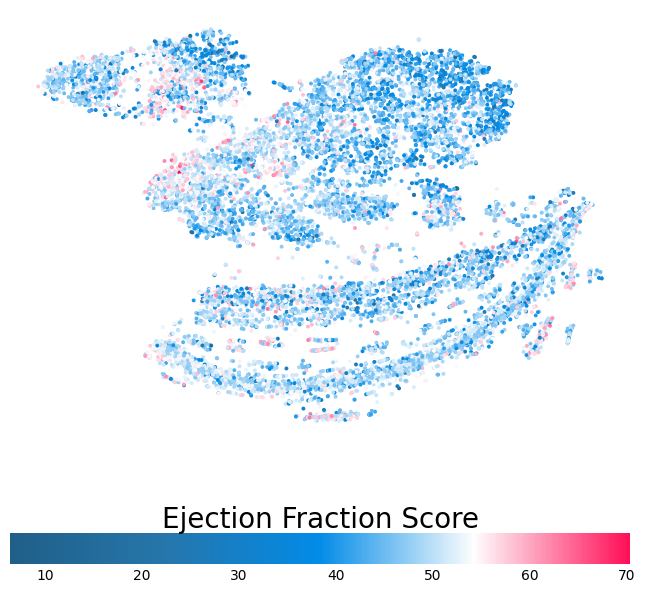

In [37]:
# Feature value clustering visualizing
f = plt.figure(figsize=(8,8))
plt.scatter(feature_embedded[:,0],
           feature_embedded[:,1],
           c=shap_tsne_values.sum(1).astype(np.float64)+ef_mean,
           linewidth=0, alpha=1, s = 8, cmap=LinearSegmentedColormap.from_list('shap2',clist_ef))
cb = plt.colorbar(aspect=20, orientation="horizontal")
cb.set_label("Ejection Fraction Score",fontsize=20)
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")

In [38]:
# plot the supervised clustering with t-SNE and SHAP values of different features
def plot_tsne(feature, fig, ax, row, col, ticks, labels, feature_name,cm_name,cnt):
    im = ax[row][col].scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X_test_c[feature][:N].astype(np.float64),
               linewidth=0, alpha=1., s=2, cmap=cm_name)
    cb = fig.colorbar(ticks=ticks,aspect=20, orientation="horizontal", ax=ax[row][col], mappable = im)
    cb.set_label(feature_name,fontsize=5,fontweight='bold')
    cb.ax.set_xticklabels(labels = labels,fontsize=7,fontweight='bold')
    cb.set_alpha(1)
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    ax[row][col].axis('off')
    ax[row][col].text(-55,55,cnt,fontsize=12)

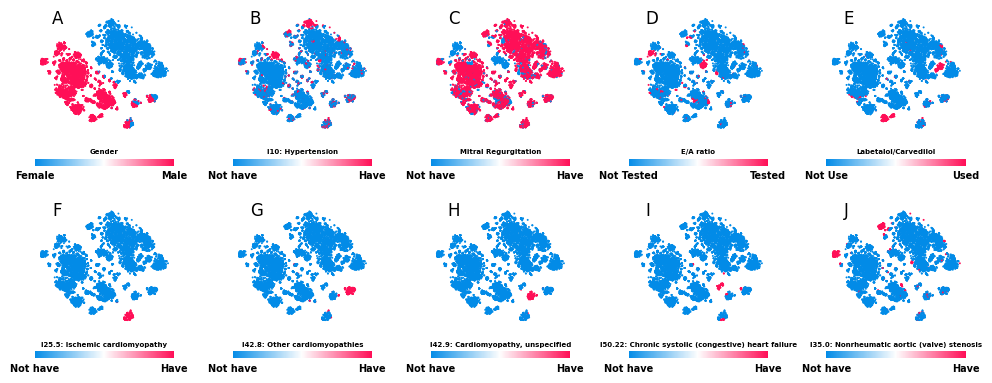

In [39]:
# typical demographics, diagnoses, medical dispenses and tests.
fig,ax=plt.subplots(2,5,figsize=(10,4))

plot_tsne(feature = 'DEMO_GENDER',fig = fig,ax = ax,row = 0,col = 0, 
          ticks = [0,1],labels = ['Female','Male'], feature_name = 'Gender', # 性别
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='A')
plot_tsne(feature = 'DI_I10', fig = fig, ax = ax, row = 0, col = 1,
          ticks = [0,1],labels = ['Not have','Have'],feature_name = 'I10: Hypertension', # 高血压
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='B')
plot_tsne(feature = "OR_MITRAL REGURGITATION",fig = fig, ax = ax,row = 0, col = 2,
          ticks = [0,1],labels = ['Not have','Have'],feature_name = 'Mitral Regurgitation',
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='C')
plot_tsne(feature = "OR_MITRAL E TO A RATIO",fig = fig,ax = ax,row = 0,col = 3,
          ticks = [0,1], labels = ['Not Tested','Tested'], feature_name = 'E/A ratio', # E/A 比值
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='D')
plot_tsne(feature = 'MD_C07AG', fig = fig, ax = ax, row = 0, col = 4,
          ticks = [0,1],labels = ['Not Use','Used'], feature_name = 'Labetalol/Carvedilol', # α/β受体阻断药
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='E')
plot_tsne(feature = "DI_I255",fig = fig, ax = ax, row = 1, col = 0,
          ticks = [0,1],labels = ['Not have','Have'],feature_name = 'I25.5: Ischemic cardiomyopathy', # 缺血性心肌病
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='F')
plot_tsne(feature = "DI_I428",fig = fig, ax = ax,row = 1, col = 1,
          ticks = [0,1],labels = ['Not have','Have'],feature_name = 'I42.8: Other cardiomyopathies', # 其他心肌病
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='G')
plot_tsne(feature = "DI_I429",fig = fig, ax = ax,row = 1, col = 2,
          ticks = [0,1],labels = ['Not have','Have'],feature_name = 'I42.9: Cardiomyopathy, unspecified', # 未特指心肌病
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='H')
plot_tsne(feature = "DI_I5022",fig = fig, ax = ax,row = 1, col = 3,
          ticks = [0,1],labels = ['Not have','Have'],feature_name = 'I50.22: Chronic systolic (congestive) heart failure',
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='I')          # 慢性收缩期(充血性)心力衰竭
        # 二尖瓣闭锁不全
plot_tsne(feature = "DI_I350",fig = fig, ax = ax,row = 1, col = 4,
          ticks = [0,1],labels = ['Not have','Have'],feature_name = 'I35.0: Nonrheumatic aortic (valve) stenosis',
         cm_name = LinearSegmentedColormap.from_list('shap',clist1),cnt='J')          # 非风湿性主动脉狭窄
plt.tight_layout()

In [40]:
gender_flag = ["Male" if shap_values[i,"DEMO_GENDER"].data == 0 else "Female" for i in range(shap_values.shape[0])]
mit_flag = ["Not have" if shap_values[i,"OR_MITRAL REGURGITATION"].data == 0 else "Have" for i in range(shap_values.shape[0])]
i10_flag = ["Not have" if shap_values[i,"DI_I10"].data == 0 else "Have" for i in range(shap_values.shape[0])]
i255_flag = ["Not have" if shap_values[i,"DI_I255"].data == 0 else "Have" for i in range(shap_values.shape[0])]
i428_flag = ["Not have" if shap_values[i,"DI_I428"].data == 0 else "Have" for i in range(shap_values.shape[0])]
i429_flag = ["Not have" if shap_values[i,"DI_I429"].data == 0 else "Have" for i in range(shap_values.shape[0])]
i5022_flag = ["Not have" if shap_values[i,"DI_I5022"].data == 0 else "Have" for i in range(shap_values.shape[0])]
c07ag_flag = ["Not have" if shap_values[i,"MD_C07AG"].data == 0 else "Have" for i in range(shap_values.shape[0])]
i350_flag = ["Not have" if shap_values[i,"DI_I350"].data == 0 else "Have" for i in range(shap_values.shape[0])]
ea_flag = ["Not have" if shap_values[i,"OR_MITRAL E TO A RATIO"].data == 0 else "Have" for i in range(shap_values.shape[0])]

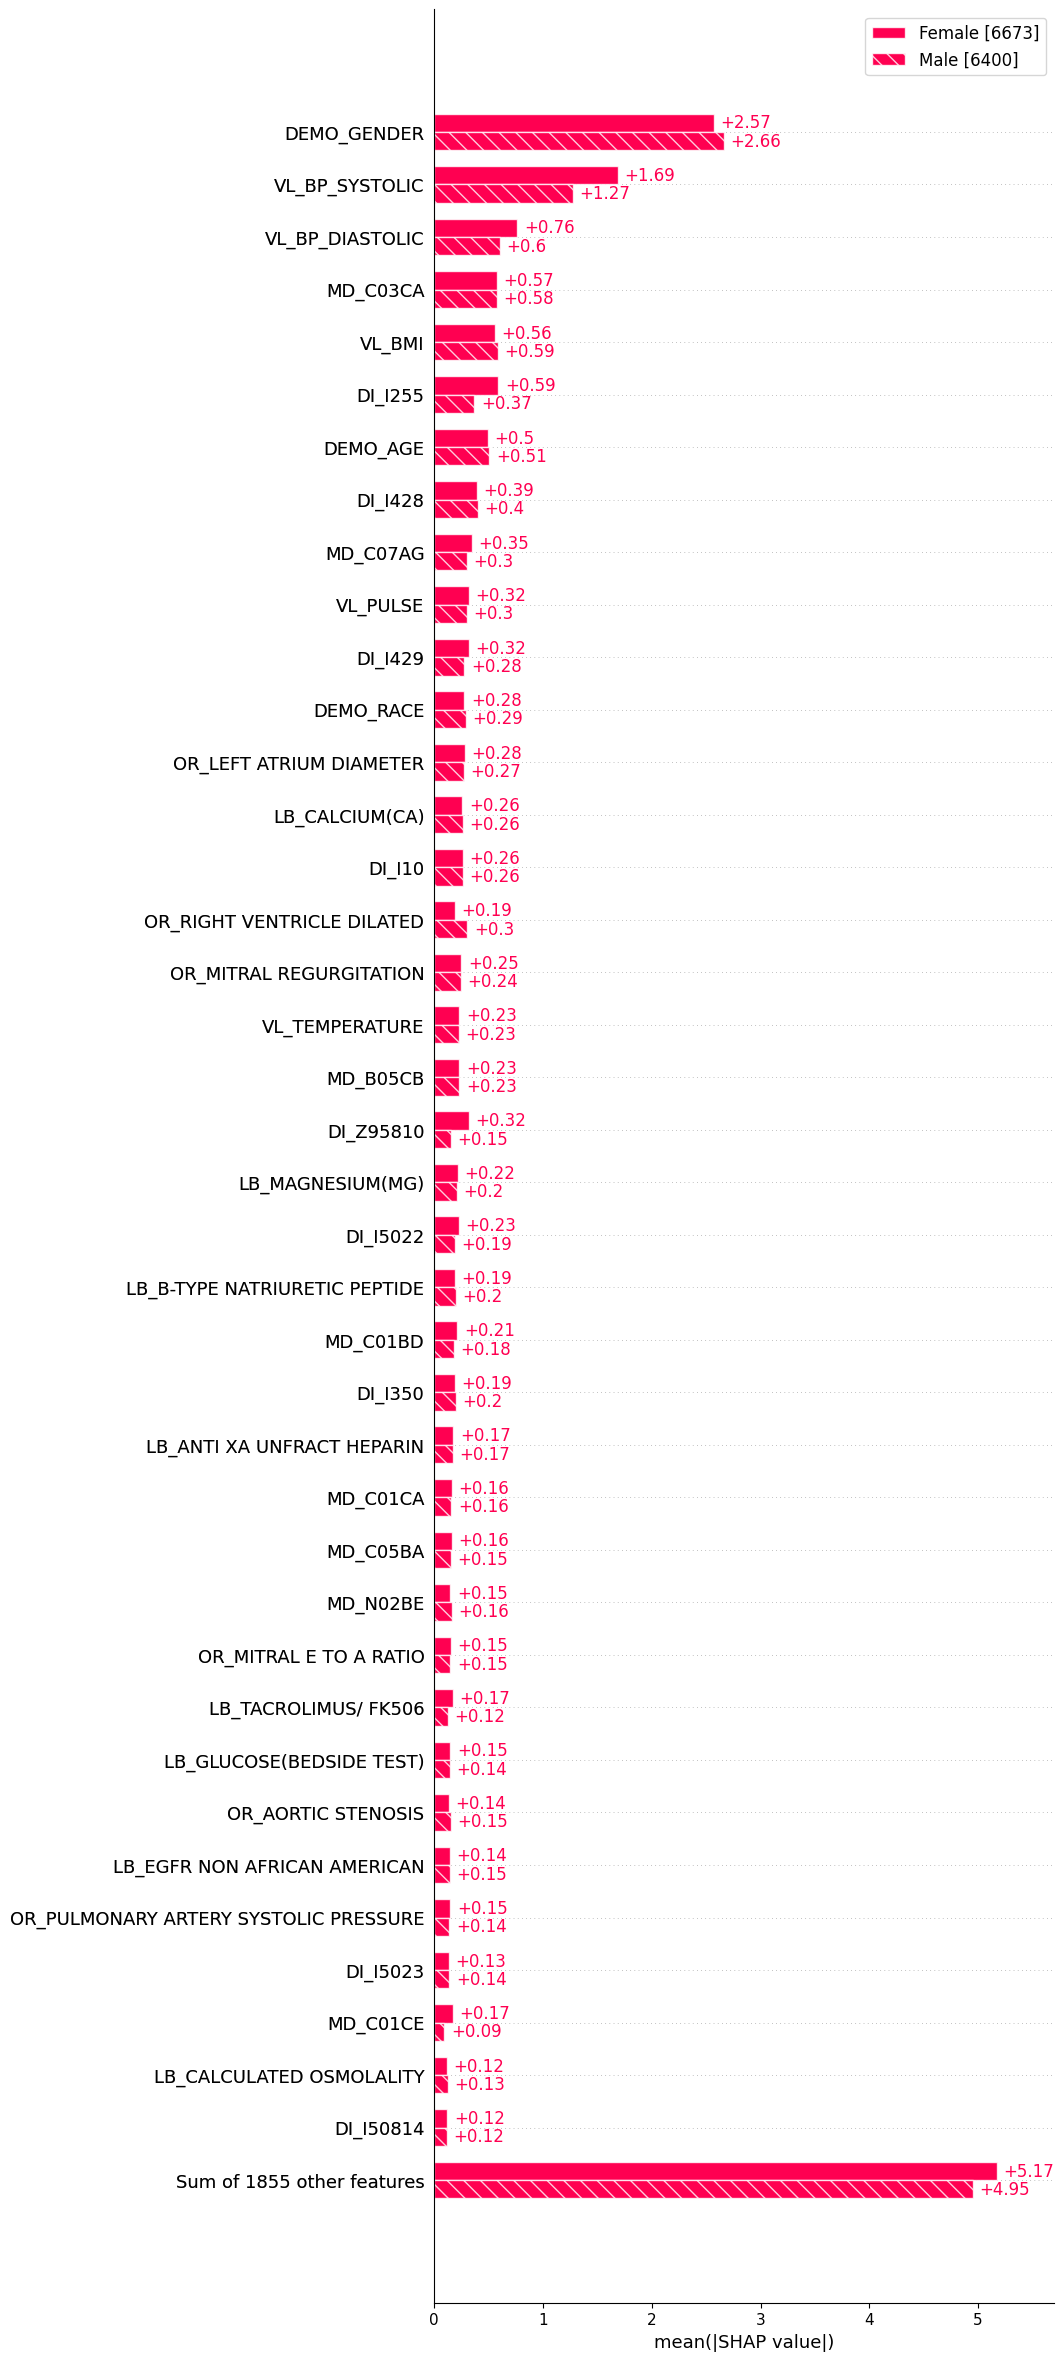

In [41]:
#Change the cur_flag with different flags above to see the influence of different features
cur_flag = gender_flag
shap.plots.bar(shap_values.cohorts(cur_flag).abs.mean(0),max_display=40)

### SHAP Ratio result table
![SHAP RATIO TABLE](./pics/shap-ratio.png)